In [62]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import json


In [2]:
full_df = pd.read_pickle('/data/newhouse/LRT/batch/master/training/tracks_weighted.pkl')

In [3]:
inputs_names = [ 
"z0",
"d0",
"numberOfSCTHits",
"Sihits",
"eta",
"numberDoF",
"geometric_var",
"numberOfSCTHoles",
]
label_names = ["is_good"]

df = full_df[inputs_names + label_names]
df

,z0,d0,numberOfSCTHits,Sihits,eta,numberDoF,geometric_var,numberOfSCTHoles,is_good
669124,148.534220,104.480734,7.0,9.0,-1.206826,6.0,1.947236,1.0,False
399311,-60.601026,-48.070017,9.0,10.0,1.381759,6.0,1.978903,0.0,False
313684,376.808424,99.458298,7.0,8.0,1.907424,4.0,0.036708,0.0,False
1583973,-81.997203,60.224389,8.0,9.0,1.302603,5.0,1.977285,0.0,True
2137964,-147.780404,21.521041,10.0,11.0,-2.370948,7.0,0.041632,0.0,True
...,...,...,...,...,...,...,...,...,...
2798810,-277.100815,24.420583,8.0,8.0,-2.205237,3.0,0.131661,0.0,True
425099,-327.316654,-19.400785,6.0,8.0,2.422333,5.0,2.905424,0.0,False
568234,66.349742,-19.168792,7.0,8.0,-0.830667,4.0,2.038449,1.0,False
2724619,-23.873419,-20.035454,8.0,8.0,0.082437,3.0,0.954928,0.0,True


In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)

Model: "r3lrt_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________

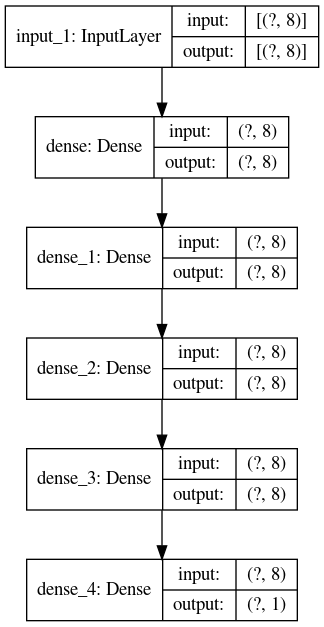

In [5]:
# Create model
def create_model():
    in_len = len(inputs_names)
    # Input layer
    inputs = keras.Input(shape=(len(inputs_names),))

    # Hidden layers
    dense = layers.Dense(in_len, activation="relu")
    x = dense(inputs)
    x = layers.Dense(in_len, activation="relu")(x)
    x = layers.Dense(in_len, activation="relu")(x)
    x = layers.Dense(in_len, activation="relu")(x)
    
    # Output layer
    outputs = layers.Dense(1,  activation="sigmoid")(x)    
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="r3lrt_model")
    print(model.summary())
    
    return model

model = create_model()
keras.utils.plot_model(model, "r3lrt_model.png", show_shapes=True)

In [22]:
# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer = keras.optimizers.Adamax(lr=0.0003),
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

In [23]:
history = model.fit(train[inputs_names], 
                    train[label_names], 
                    epochs=50, 
                    batch_size=500,
                    validation_data=(test[inputs_names], 
                                     test[label_names]),
#                     callbacks=[plot, early_stop, GetBest(monitor='val_acc', verbose=1, mode='max') ], 
#                     validation_data=(df[inputs_names][100:120], df[label_names][100:120], ),
#                     sample_weight = train_weights
                   )

Epoch 1/50
240/240 [==============================] - 1s 6ms/step - loss: 0.3244 - accuracy: 0.8591 - precision_2: 0.8752 - recall_2: 0.8385 - val_loss: 0.3158 - val_accuracy: 0.8618 - val_precision_2: 0.8733 - val_recall_2: 0.8441
Epoch 2/50
240/240 [==============================] - 1s 5ms/step - loss: 0.3243 - accuracy: 0.8589 - precision_2: 0.8752 - recall_2: 0.8379 - val_loss: 0.3162 - val_accuracy: 0.8611 - val_precision_2: 0.8682 - val_recall_2: 0.8491
Epoch 3/50
240/240 [==============================] - 1s 4ms/step - loss: 0.3245 - accuracy: 0.8590 - precision_2: 0.8752 - recall_2: 0.8382 - val_loss: 0.3159 - val_accuracy: 0.8633 - val_precision_2: 0.8821 - val_recall_2: 0.8363
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3244 - accuracy: 0.8585 - precision_2: 0.8749 - recall_2: 0.8374 - val_loss: 0.3154 - val_accuracy: 0.8620 - val_precision_2: 0.8742 - val_recall_2: 0.8433
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss

240/240 [==============================] - 1s 4ms/step - loss: 0.3237 - accuracy: 0.8585 - precision_2: 0.8751 - recall_2: 0.8373 - val_loss: 0.3159 - val_accuracy: 0.8619 - val_precision_2: 0.8686 - val_recall_2: 0.8505
Epoch 37/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3236 - accuracy: 0.8590 - precision_2: 0.8759 - recall_2: 0.8373 - val_loss: 0.3152 - val_accuracy: 0.8625 - val_precision_2: 0.8762 - val_recall_2: 0.8420
Epoch 38/50
240/240 [==============================] - 1s 3ms/step - loss: 0.3237 - accuracy: 0.8589 - precision_2: 0.8753 - recall_2: 0.8378 - val_loss: 0.3154 - val_accuracy: 0.8629 - val_precision_2: 0.8816 - val_recall_2: 0.8361
Epoch 39/50
240/240 [==============================] - 1s 4ms/step - loss: 0.3238 - accuracy: 0.8589 - precision_2: 0.8756 - recall_2: 0.8375 - val_loss: 0.3152 - val_accuracy: 0.8630 - val_precision_2: 0.8774 - val_recall_2: 0.8416
Epoch 40/50
240/240 [==============================] - 1s 4ms/step - loss: 0.323

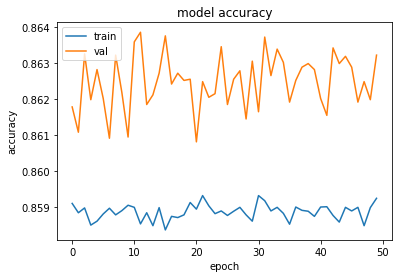

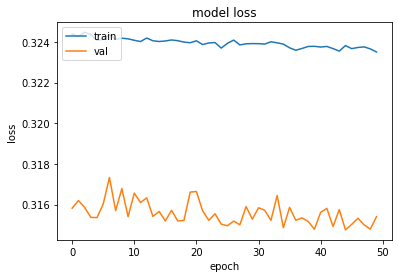

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [95]:
model_dir = '/home/newhouse/tmp/model/'
lwtnn_dir = '/home/newhouse/public/Analysis/LRT/lwtnn/'

# save architecture
arch = model.to_json()
with open(f'{model_dir}architecture.json', 'w') as arch_file:
    arch_file.write(arch)
# now save the weights as an HDF5 file
model.save_weights(f'{model_dir}weights.h5')

# Generate variables file with lwtnn
make_variables_command = f'{lwtnn_dir}converters/kerasfunc2json.py {model_dir}architecture.json {model_dir}weights.h5 > {model_dir}variables.json'
print(make_variables_command)
if os.system(make_variables_command) == 0:
    print('success')
else:
    print('failure')
    

/home/newhouse/public/Analysis/LRT/lwtnn/converters/kerasfunc2json.py /home/newhouse/tmp/model/architecture.json /home/newhouse/tmp/model/weights.h5 > /home/newhouse/tmp/model/variables.json
success


In [90]:
# or manually make the variables file
with open(f'{model_dir}variables.json', 'r') as variables_json:
    inputs_dict = json.load(variables_json)

# update the names to the correct variables
for item, df_name in zip(inputs_dict['inputs'][0]['variables'], inputs_names):
    print(item['name'], '->', df_name)
    item['name'] = df_name

# do the same with the output label
print()
print(inputs_dict['outputs'][0]['labels'][0], '->', 'nn_score')
inputs_dict['outputs'][0]['labels'][0] = 'nn_score'
    
with open(f'{model_dir}variables.json', 'w') as variables_json:
    inputs_dict = json.dump(inputs_dict, variables_json, indent=2 )

z0 -> z0
d0 -> d0
numberOfSCTHits -> numberOfSCTHits
Sihits -> Sihits
eta -> eta
numberDoF -> numberDoF
geometric_var -> geometric_var
numberOfSCTHoles -> numberOfSCTHoles

nn_score -> nn_score


In [96]:
kerasfunc2json_command = f'{lwtnn_dir}converters/kerasfunc2json.py {model_dir}architecture.json {model_dir}weights.h5 {model_dir}variables.json > {model_dir}nn-config.json'
print(kerasfunc2json_command)
if os.system(kerasfunc2json_command) == 0:
    print('success')
else:
    print('failure')
    

/home/newhouse/public/Analysis/LRT/lwtnn/converters/kerasfunc2json.py /home/newhouse/tmp/model/architecture.json /home/newhouse/tmp/model/weights.h5 /home/newhouse/tmp/model/variables.json > /home/newhouse/tmp/model/nn-config.json
success
